# Neuquen Sediment Basin Forward Model with Variable Density

## Import Packages

In [1]:
%matplotlib inline

from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from fatiando import gridder
from fatiando.mesher import Tesseroid
from matplotlib.colors import LightSource

from tesseroid_density import tesseroid
from tesseroid_relief import TesseroidRelief

## Study Area

In [2]:
data = np.load("../data/topography.npy")
lat, lon, topo = data[:, 0], data[:, 1], data[:, 2]
shape = (571, 457)
area = (lat.min(), lat.max(), lon.min(), lon.max())

topography = {'lon': lon, 'lat': lat, 'topo': topo,
              'shape': shape, 'area': area}

/home/santi/.anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/santi/.anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


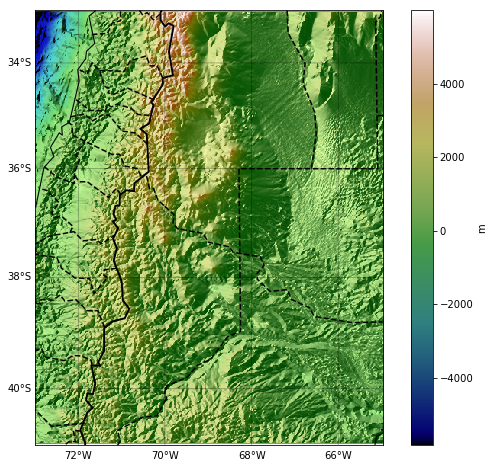

In [3]:
fig, ax = plt.subplots(figsize=(10, 8))

bm = Basemap(projection='merc',
             llcrnrlon=area[2],
             llcrnrlat=area[0],
             urcrnrlon=area[3],
             urcrnrlat=area[1],
             resolution='l')

topo = np.ma.masked_array(topography['topo'],
                          np.isnan(topo))
x, y = bm(topography['lon'], topography['lat'])
cmap = plt.cm.gist_earth
vmax = np.abs([np.nanmin(topo), np.nanmax(topo)]).max()
vmin = -vmax
shape = topography['shape']

# Hillshaded topography
ls = LightSource(azdeg=240, altdeg=45)
rgb = ls.shade(topo.reshape(shape), cmap,
               blend_mode='overlay', vmin=vmin, vmax=vmax)
bm.imshow(rgb)

# Proxy image for colorbar
im = bm.imshow(topo.reshape(shape), cmap=cmap)
im.remove()
plt.colorbar(im, label='m')

bm.drawcountries(linewidth=1.9, color='k')
bm.drawstates(linewidth=1.5, linestyle='--', color='k')
bm.drawcoastlines(linewidth=1.1, color='k')
bm.drawmeridians(np.arange(-80, -50, 2), linewidth=0.5,
                 labels=[False, False, False, True])
bm.drawparallels(np.arange(-50, -30, 2), linewidth=0.5,
                 labels=[True, False, False, False])
plt.show()

## Load sediment thickness data

In [4]:
lat, lon, thickness = np.loadtxt('../data/sediment_thickness.dat',
                                 unpack=True)
thickness = -thickness
shape = (117, 91)

## Downsample
lat = np.ravel(lat.reshape(shape)[::3, ::3])
lon = np.ravel(lon.reshape(shape)[::3, ::3])
thickness = np.ravel(thickness.reshape(shape)[::3, ::3])
shape = (shape[0]//3, shape[1]//3 + 1)
area = (lat.min(), lat.max(), lon.min(), lon.max())

print shape
print lat.size, thickness.size
print shape[0]*shape[1]

sediments = {'lon': lon, 'lat':lat, 'thickness': thickness,
             'shape': shape, 'area': area}

(39, 31)
1209 1209
1209


/home/santi/.anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/santi/.anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


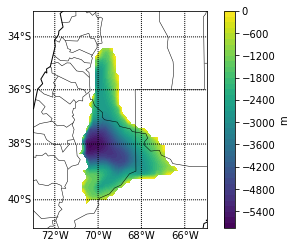

In [5]:
x, y = bm(sediments['lon'], sediments['lat'])
bm.contourf(x.reshape(sediments['shape']),
            y.reshape(sediments['shape']),
            sediments['thickness'].reshape(sediments['shape']),
            50)
bm.drawcountries()
bm.drawstates()
bm.drawcoastlines()
bm.drawmeridians(np.arange(-80, -50, 2), labels=[False, False, False, True])
bm.drawparallels(np.arange(-50, -30, 2), labels=[True, False, False, False])
plt.colorbar(label='m')
plt.show()

## Computation Grids

In [6]:
heights = [5e3, 10e3, 50e3, 100e3, 260e3]
grids = [gridder.regular(topography['area'], topography['shape'], z=height) 
         for height in heights]

## Tesseroid Model

In [7]:
def density(h):
    return -(412 - 275)/6000.*h + 275

thickness = sediments['thickness']
thickness[np.isnan(thickness)] = 0
basin = TesseroidRelief(sediments['area'], sediments['shape'],
                        thickness, 0)
basin.addprop('density', [density for i in range(basin.size)])

## Forward Computation

In [8]:
fields = 'potential gz gzz'.split()

grid = grids[1]
results = []
for field in fields:
    lat, lon, height = grid[:]
    %time result = getattr(tesseroid, field)(lon, lat, height, basin)
    results.append(result)

tesseroid_density/tesseroid.py:166: RuntimeWarning: Encountered tesseroid with dimensions smaller than the numerical threshold (1e-6 degrees or 1e-3 m). Ignoring this tesseroid.
  warnings.warn(msg, RuntimeWarning)


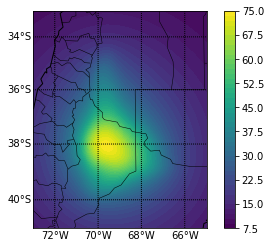

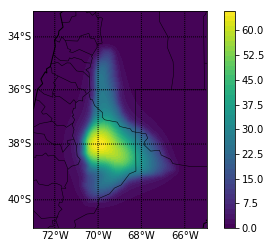

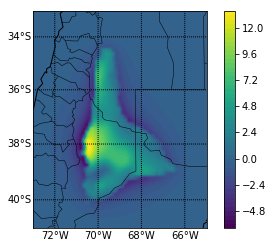

In [10]:
grid = grids[-1]
lat, lon, height = grid[:]
grid_shape = topography['shape']

for result in results:
    x, y = bm(lon, lat)
    bm.contourf(x.reshape(grid_shape),
                y.reshape(grid_shape),
                result.reshape(grid_shape),
                50)
    bm.drawcountries()
    bm.drawstates()
    bm.drawcoastlines()
    bm.drawmeridians(np.arange(-80, -50, 2), labels=[False, False, False, True])
    bm.drawparallels(np.arange(-50, -30, 2), labels=[True, False, False, False])
    plt.colorbar()
    plt.show()